# Just for testing random things

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs, is_within_range
from src.utils.misc.string_handling import string_to_tuple_list
from src.utils.results.analytics.naming import get_true_interaction_cols
from src.utils.misc.type_handling import flatten_listlike, get_first_elements
from src.utils.misc.string_handling import prettify_keys_for_label


In [5]:
fn = '../data/ensemble_mutation_effect_analysis/2023_04_11_192013/summarise_simulation/tabulated_mutation_info.csv'
info = pd.read_csv(fn)

In [46]:

# %%
num_group_cols = [e.replace('energies', 'binding_sites_groups') for e in get_true_interaction_cols(info, 'energies')]
num_bs_cols = [e.replace('energies', 'binding_sites_count') for e in get_true_interaction_cols(info, 'energies')]
bs_idxs_cols = [e.replace('energies', 'binding_sites_idxs') for e in get_true_interaction_cols(info, 'energies')]
bs_range_cols = [e.replace('energies', 'binding_site_group_range') for e in get_true_interaction_cols(info, 'energies')]


# %%
for b, g, bs, bsi, r in zip(get_true_interaction_cols(info, 'binding_sites'), num_group_cols, num_bs_cols, bs_idxs_cols, bs_range_cols):
    fbs = [string_to_tuple_list(bb) for bb in info[b]]
    first = get_first_elements(fbs, empty_replacement=[])
    info[bs] = [count_monotonic_group_lengths(bb) for bb in first]
    info[bsi] = [find_monotonic_group_idxs(bb) for bb in first]
    info[g] = info[bs].apply(len)
    info[r] = [[(bb[0], bb[-1]) for bb in b] for b in info[bsi]]

# %%
good_cols = list(info.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(info, 'binding_rates_dissociation') + get_true_interaction_cols(info, 'eqconstants') +
 get_true_interaction_cols(info, 'energies') + get_true_interaction_cols(info, 'binding_sites') + num_group_cols + num_bs_cols]
good_cols


# %%
binding_idx_map = {e.replace('energies_', ''): i for i, e in enumerate(get_true_interaction_cols(info, 'energies'))}

# %%
infom = info.melt(good_cols, value_vars=get_true_interaction_cols(info, 'energies'), var_name='idx', value_name='energies')
dfm = info.melt(good_cols, value_vars=num_group_cols, var_name='num_groups_idx', value_name='num_groups')
infom['idx_species_binding'] = dfm['num_groups_idx'].apply(lambda x: binding_idx_map[x.replace('binding_sites_groups_', '')])
infom['num_groups'] = dfm['num_groups']
dfm = info.melt(good_cols, value_vars=num_bs_cols, var_name='num_bs_idx', value_name='num_bs')
infom['num_bs'] = dfm['num_bs']

for k in ['binding_sites', 'binding_rates_dissociation', 'eqconstants']:
    dfm = info.melt(good_cols, value_vars=get_true_interaction_cols(info, k), var_name=f'{k}_idx', value_name=k)
    infom[k] = dfm[k]


# Energy diffs:

# %%
for k in ['binding_rates_dissociation', 'eqconstants', 'energies']:
    infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols(info, f'{k}')].apply(lambda x: x - x.iloc[0]).melt(value_vars=get_true_interaction_cols(info, f'{k}'), var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']


/tmp/ipykernel_182477/1088142531.py:45: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols(info, f'{k}')].apply(lambda x: x - x.iloc[0]).melt(value_vars=get_true_interaction_cols(info, f'{k}'), var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']
/tmp/ipykernel_182477/1088142531.py:45: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group

Grouping

In [47]:
infom.pivot_table('energies', ['sample_name', 'mutation_name', 'idx'], 'circuit_name')

circuit_name                            toy_mRNA_circuit_10000  \
sample_name mutation_name idx                                    
RNA_0       RNA_0_m1-0    energies_0-0                    0.00   
                          energies_0-1                    0.00   
                          energies_0-2                   -6.85   
                          energies_1-0                    0.00   
                          energies_1-1                    0.00   
...                                                        ...   
RNA_2       ref_circuit   energies_1-1                    0.00   
                          energies_1-2                   -5.29   
                          energies_2-0                   -6.60   
                          energies_2-1                   -5.29   
                          energies_2-2                    0.00   

circuit_name                            toy_mRNA_circuit_10043  \
sample_name mutation_name idx                                    
RNA_0       RNA_0_m1-0    energies_0-0                    0.00   
                          energies_0-1                   -8.46   
                          energies_0-2                  -11.87   
                          energies_1-0                   -8.46   
                          energies_1-1                    0.00   
...                                                        ...   
RNA_2       ref_circuit   energies_1-1                    0.00   
                          energies_1-2                    0.00   
                          energies_2-0                   -7.56   
                          energies_2-1                    0.00   
                          energies_2-2                    0.00   

circuit_name                            toy_mRNA_circuit_10045  \
sample_name mutation_name idx                                    
RNA_0       RNA_0_m1-0    energies_0-0                    0.00   
                          energies_0-1                   -6.96   
                          energies_0-2                  -11.48   
                          energies_1-0                   -6.96   
                          energies_1-1                    0.00   
...                                                        ...   
RNA_2       ref_circuit   energies_1-1                    0.00   
                          energies_1-2                    0.00   
                          energies_2-0                  -11.41   
                          energies_2-1                    0.00   
                          energies_2-2                    0.00   

circuit_name                            toy_mRNA_circuit_10051  \
sample_name mutation_name idx                                    
RNA_0       RNA_0_m1-0    energies_0-0                    0.00   
                          energies_0-1                    0.00   
                          energies_0-2                   -6.39   
                          energies_1-0                    0.00   
                          energies_1-1                    0.00   
...                                                        ...   
RNA_2       ref_circuit   energies_1-1                    0.00   
                          energies_1-2                   -1.00   
                          energies_2-0                   -6.38   
                          energies_2-1                   -1.00   
                          energies_2-2                    0.00   

circuit_name                            toy_mRNA_circuit_10053  \
sample_name mutation_name idx                                    
RNA_0       RNA_0_m1-0    energies_0-0                    0.00   
                          energies_0-1                    0.00   
                          energies_0-2                    0.00   
                          energies_1-0                    0.00   
                          energies_1-1                    0.00   
...                                                        ...   
RNA_2       ref_circuit   energies_1

In [49]:
grp_mutations = infom.pivot_table('energies', ['sample_name', 'mutation_name', 'idx'], 'circuit_name').T.to_numpy()
scaled_data = StandardScaler().fit_transform(grp_mutations)


In [9]:
data = info[(info['sample_name'] == 'RNA_1')].dropna(axis=1)
# data = data[np.abs(data[numerical_cols]) < 1e11]
d = data[['sensitivity_wrt_species-6', 'precision_wrt_species-6']]
scaled_data_sp = StandardScaler().fit_transform(d)

In [50]:
reducer = umap.UMAP()
UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)
embedding = reducer.fit_transform(grp_mutations)
# embedding = reducer.embedding_
embedding.shape

(1000, 2)

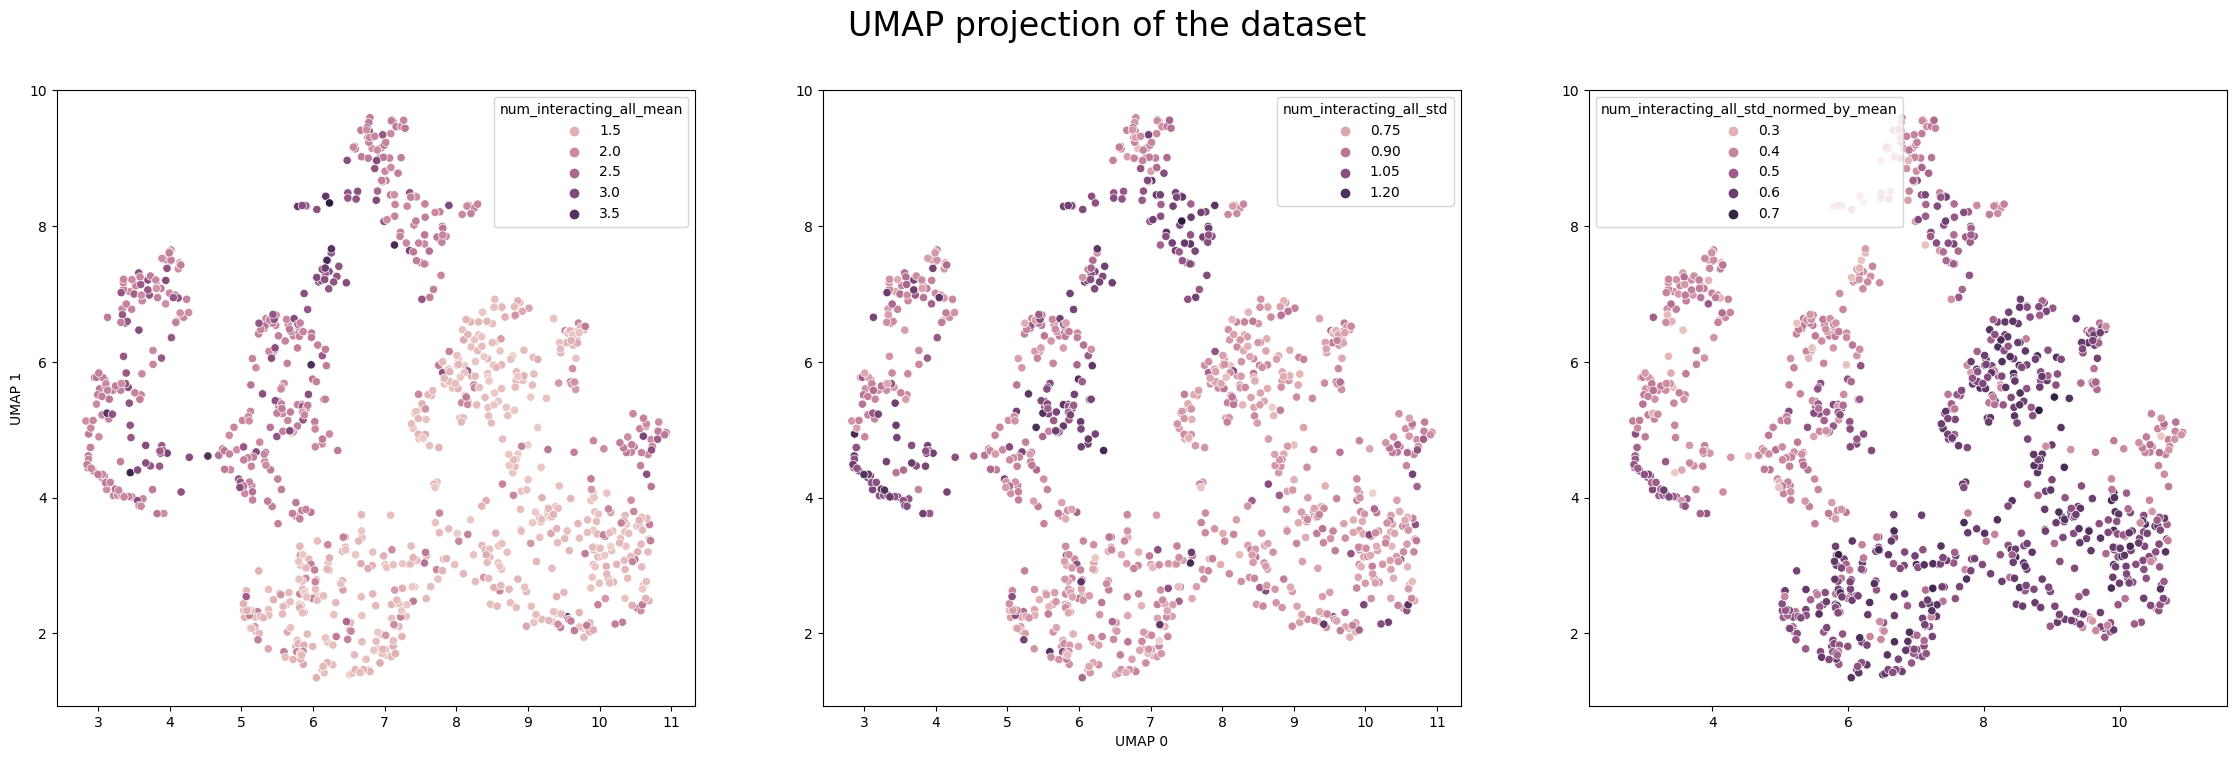

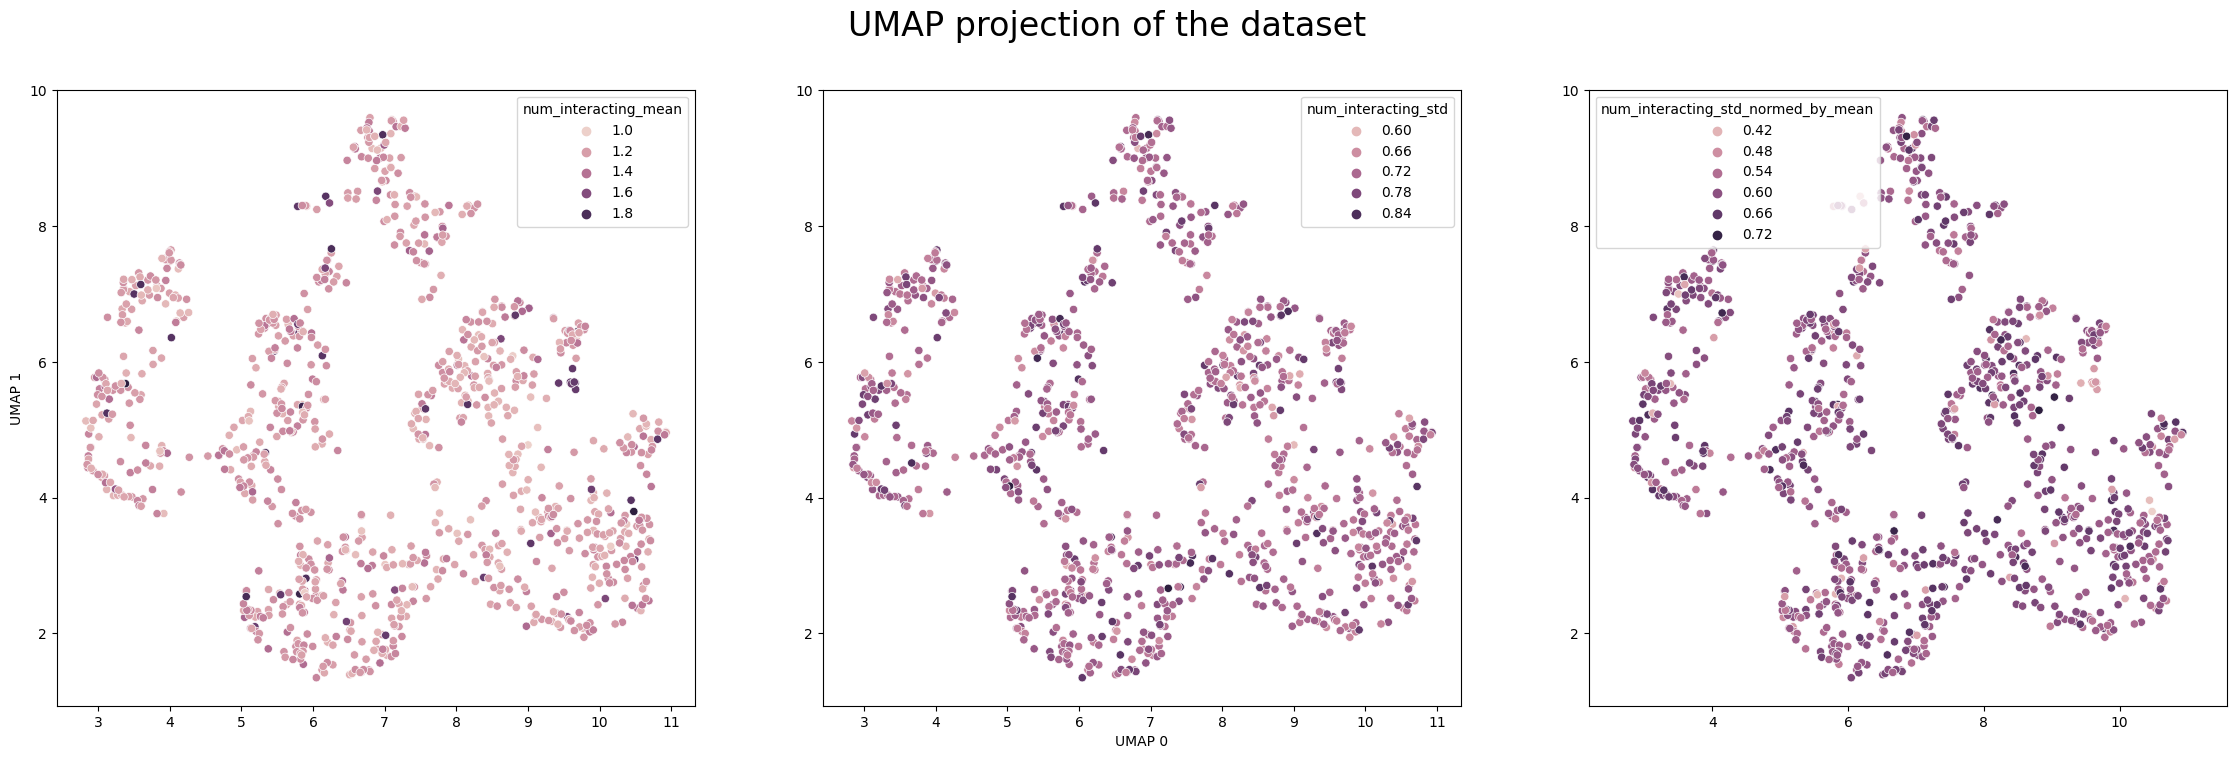

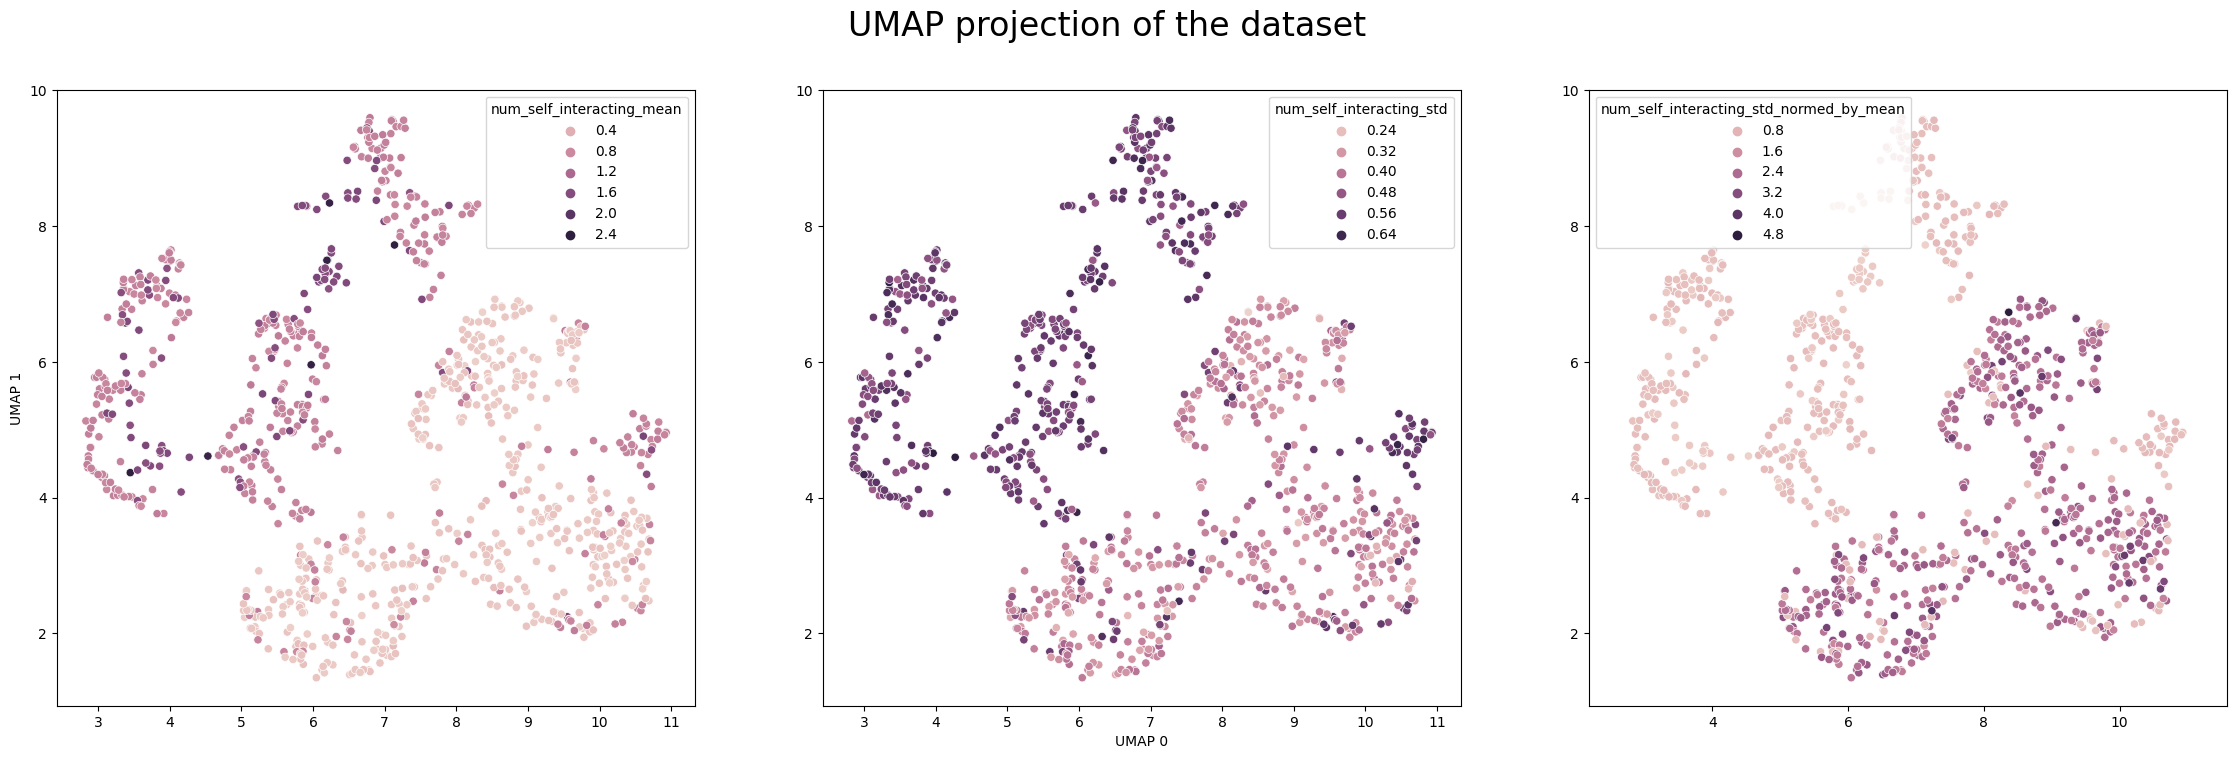

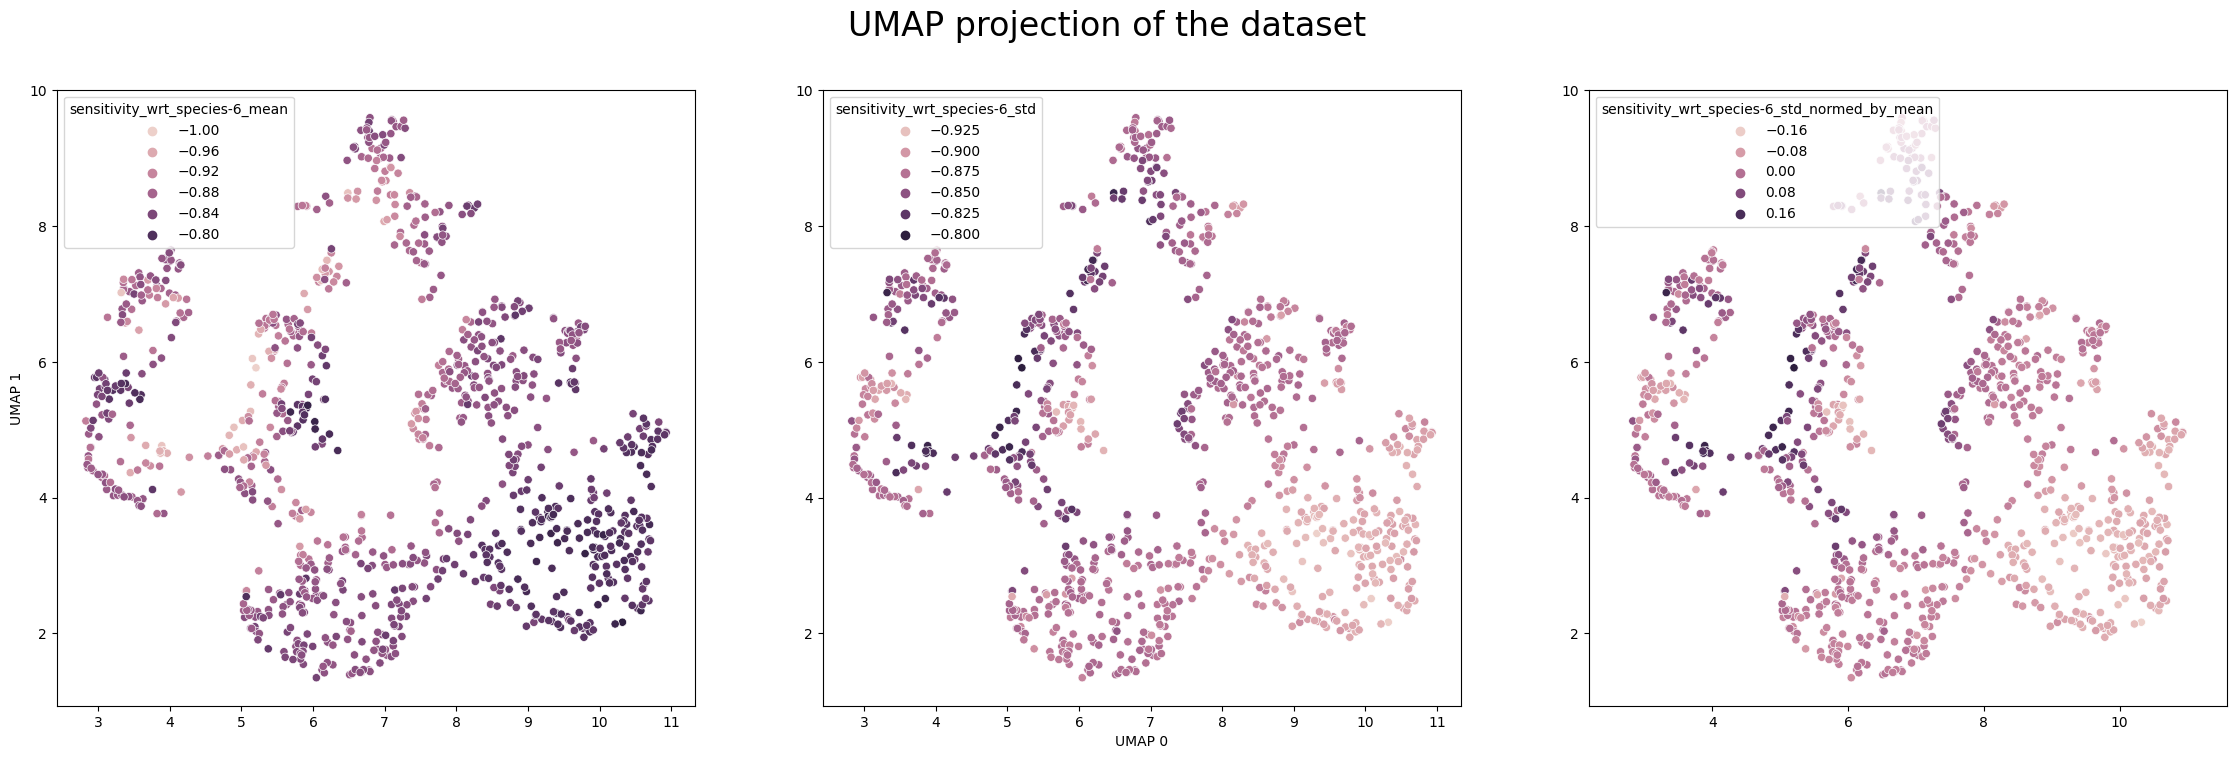

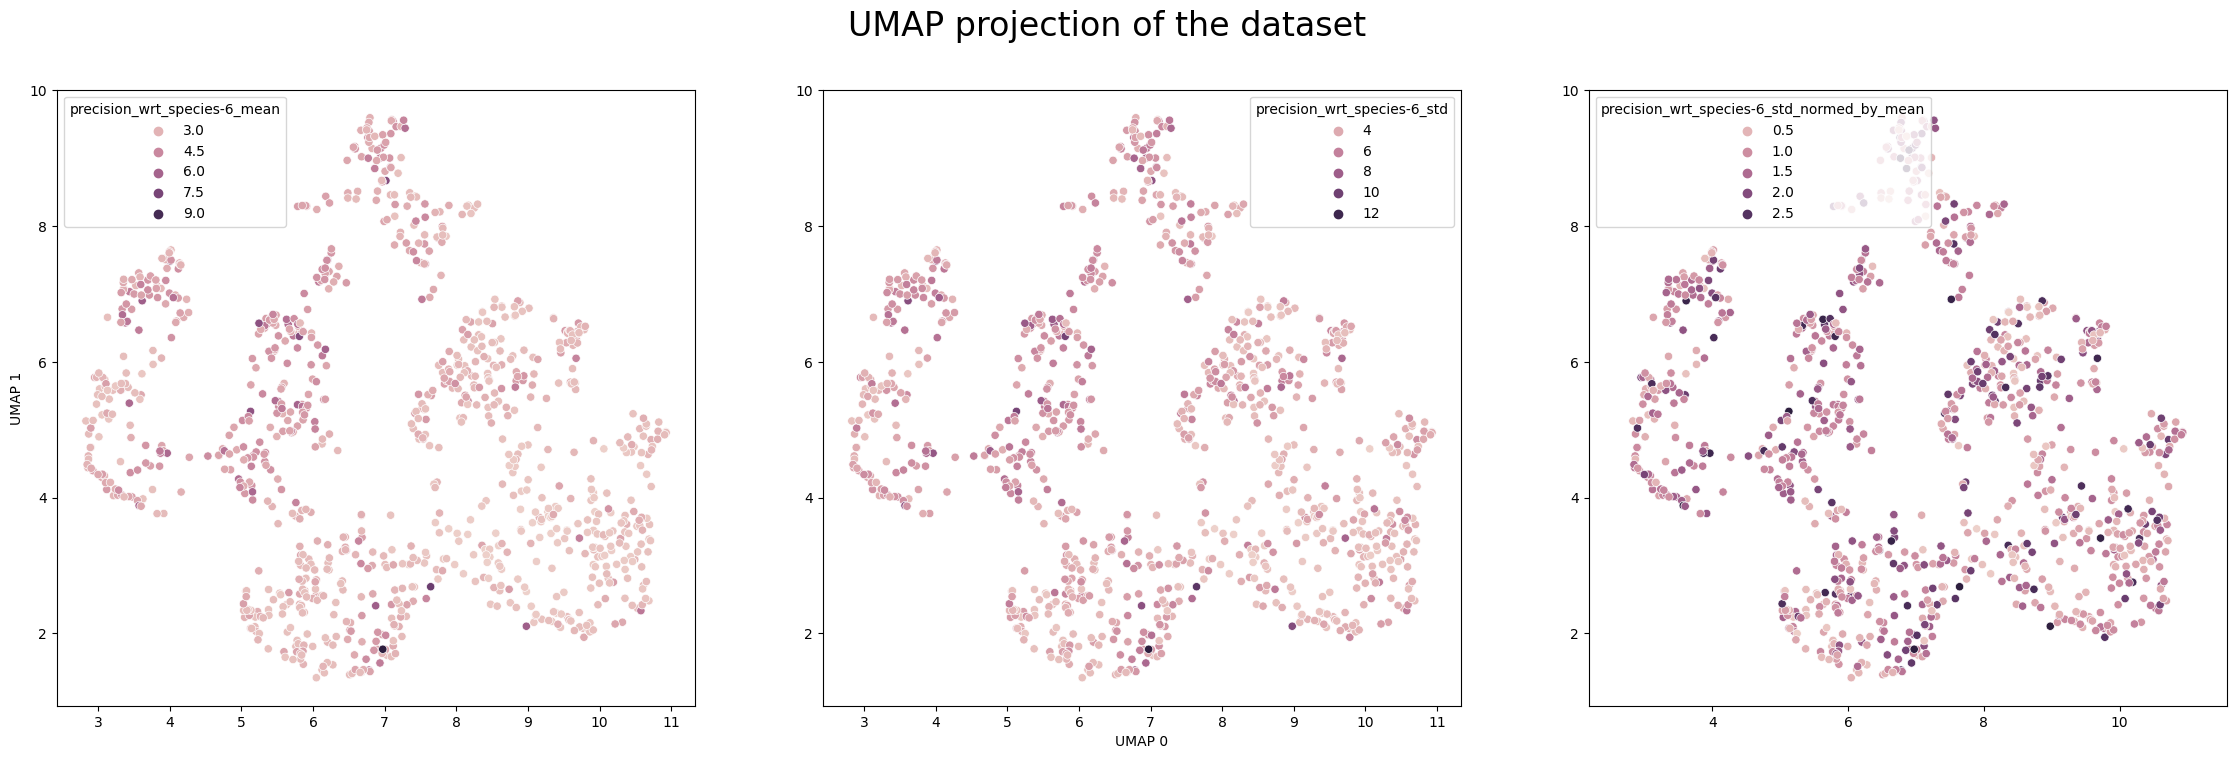

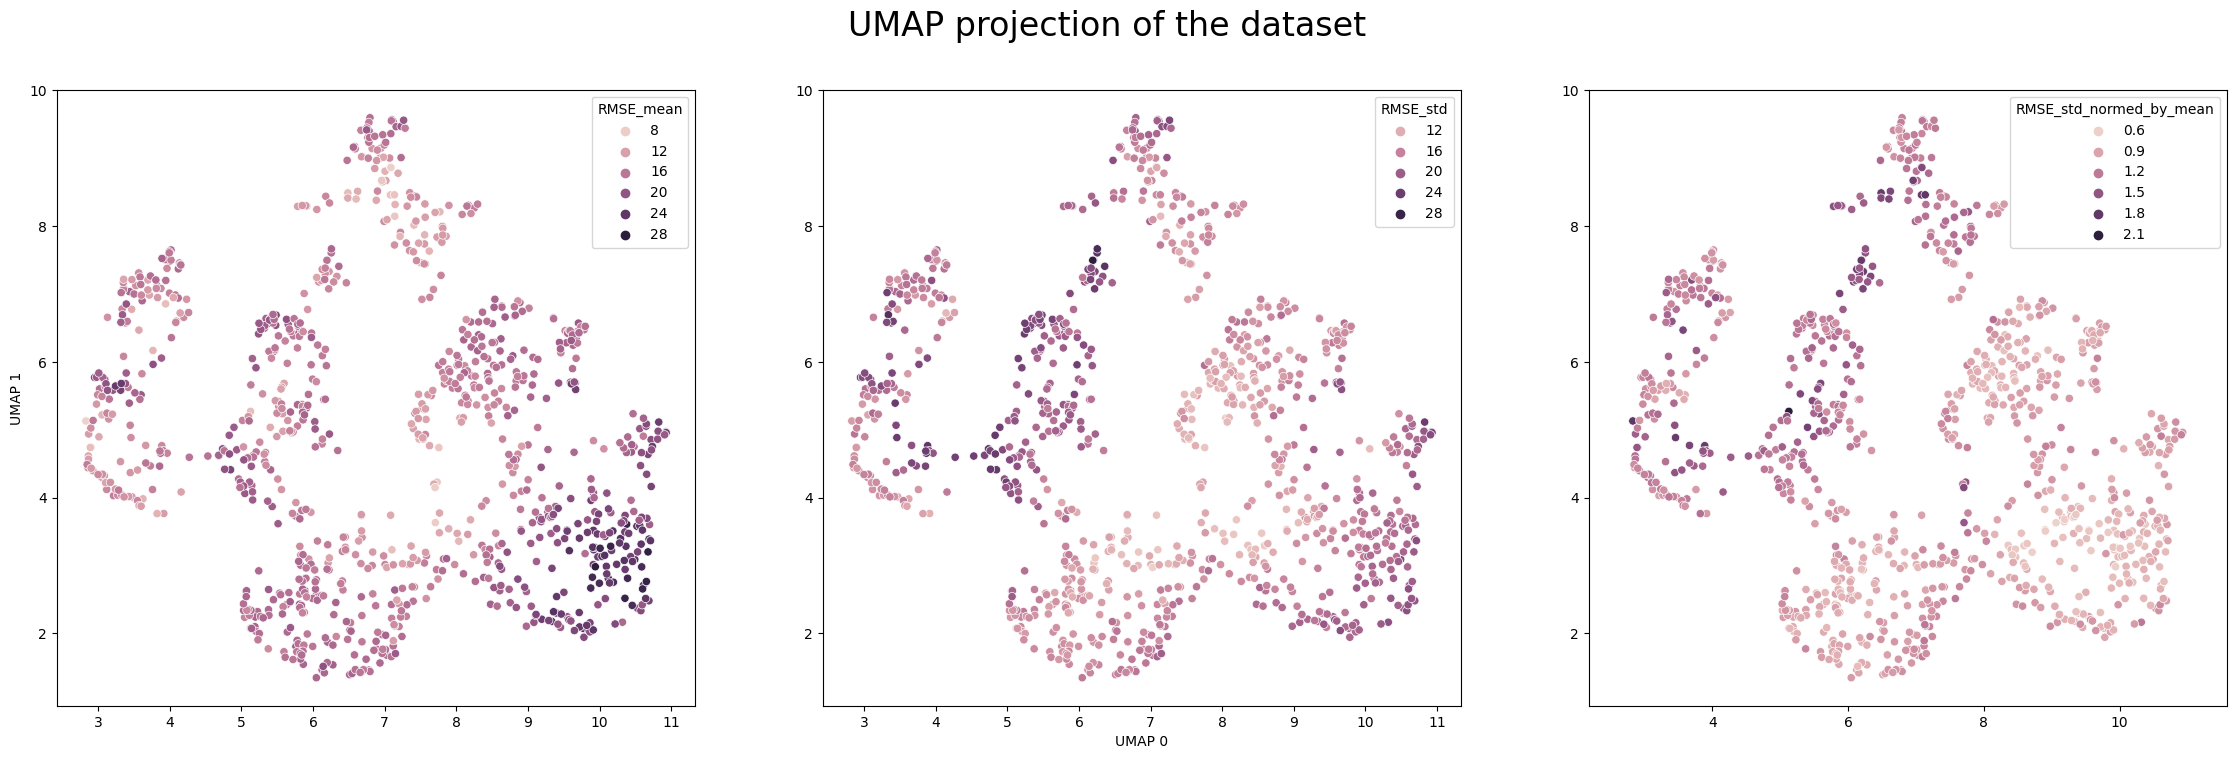

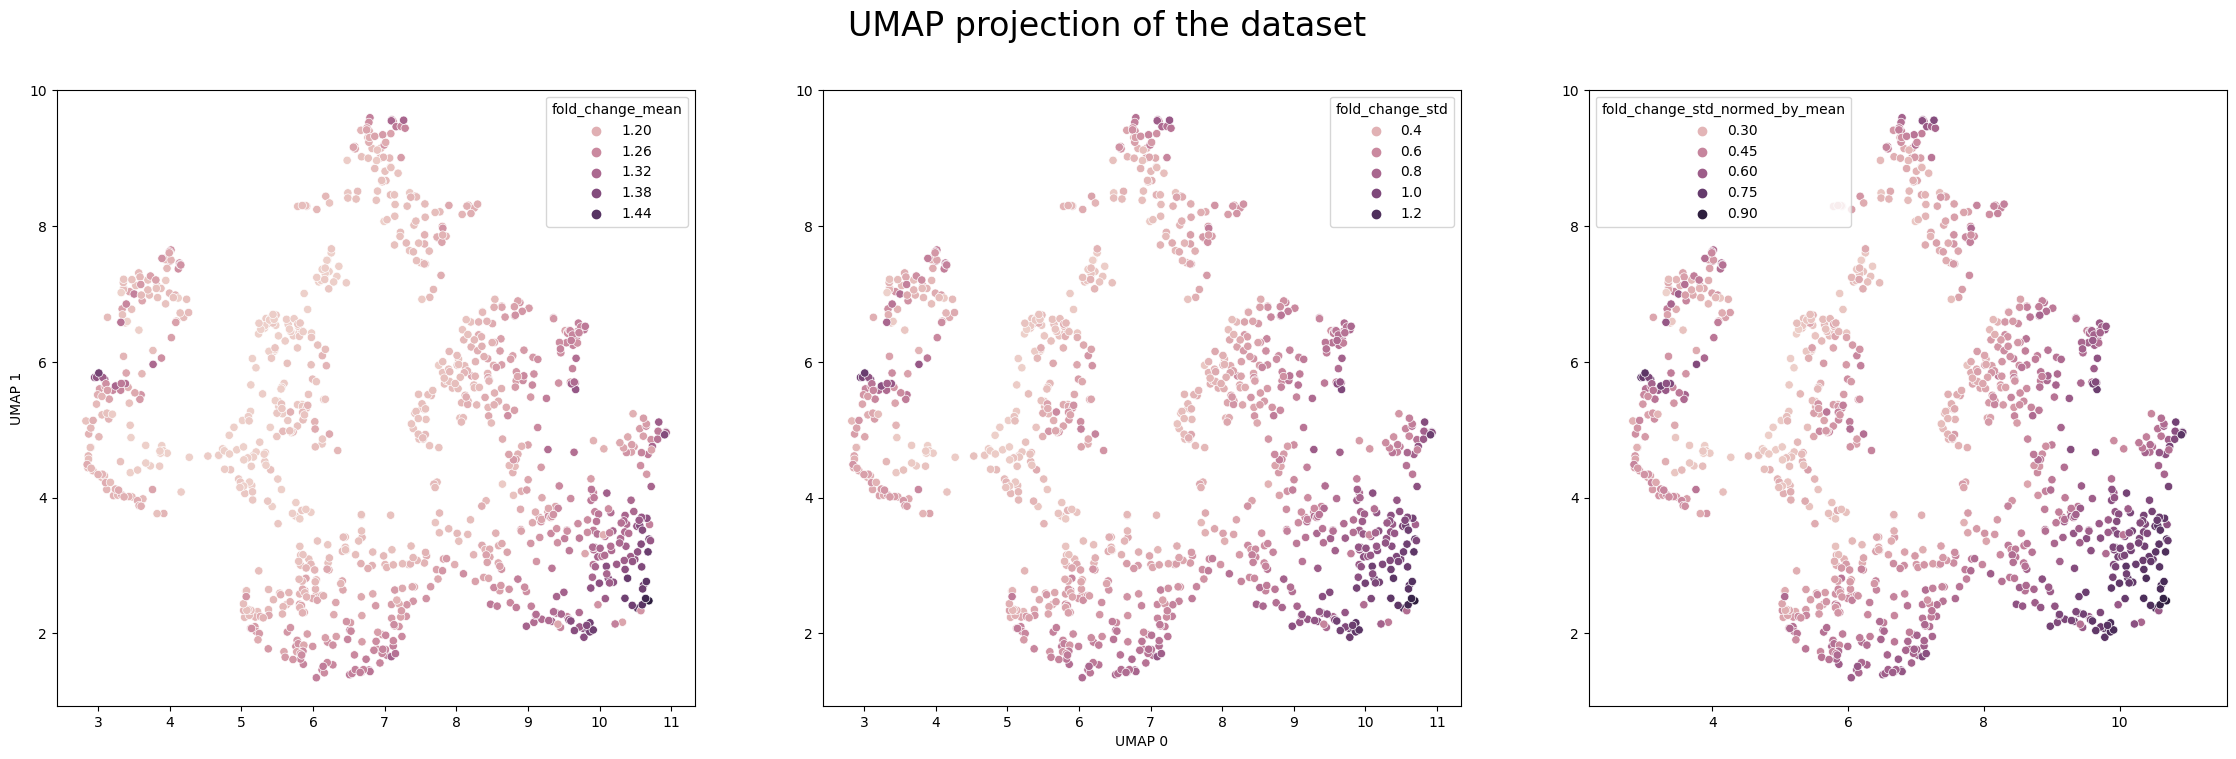

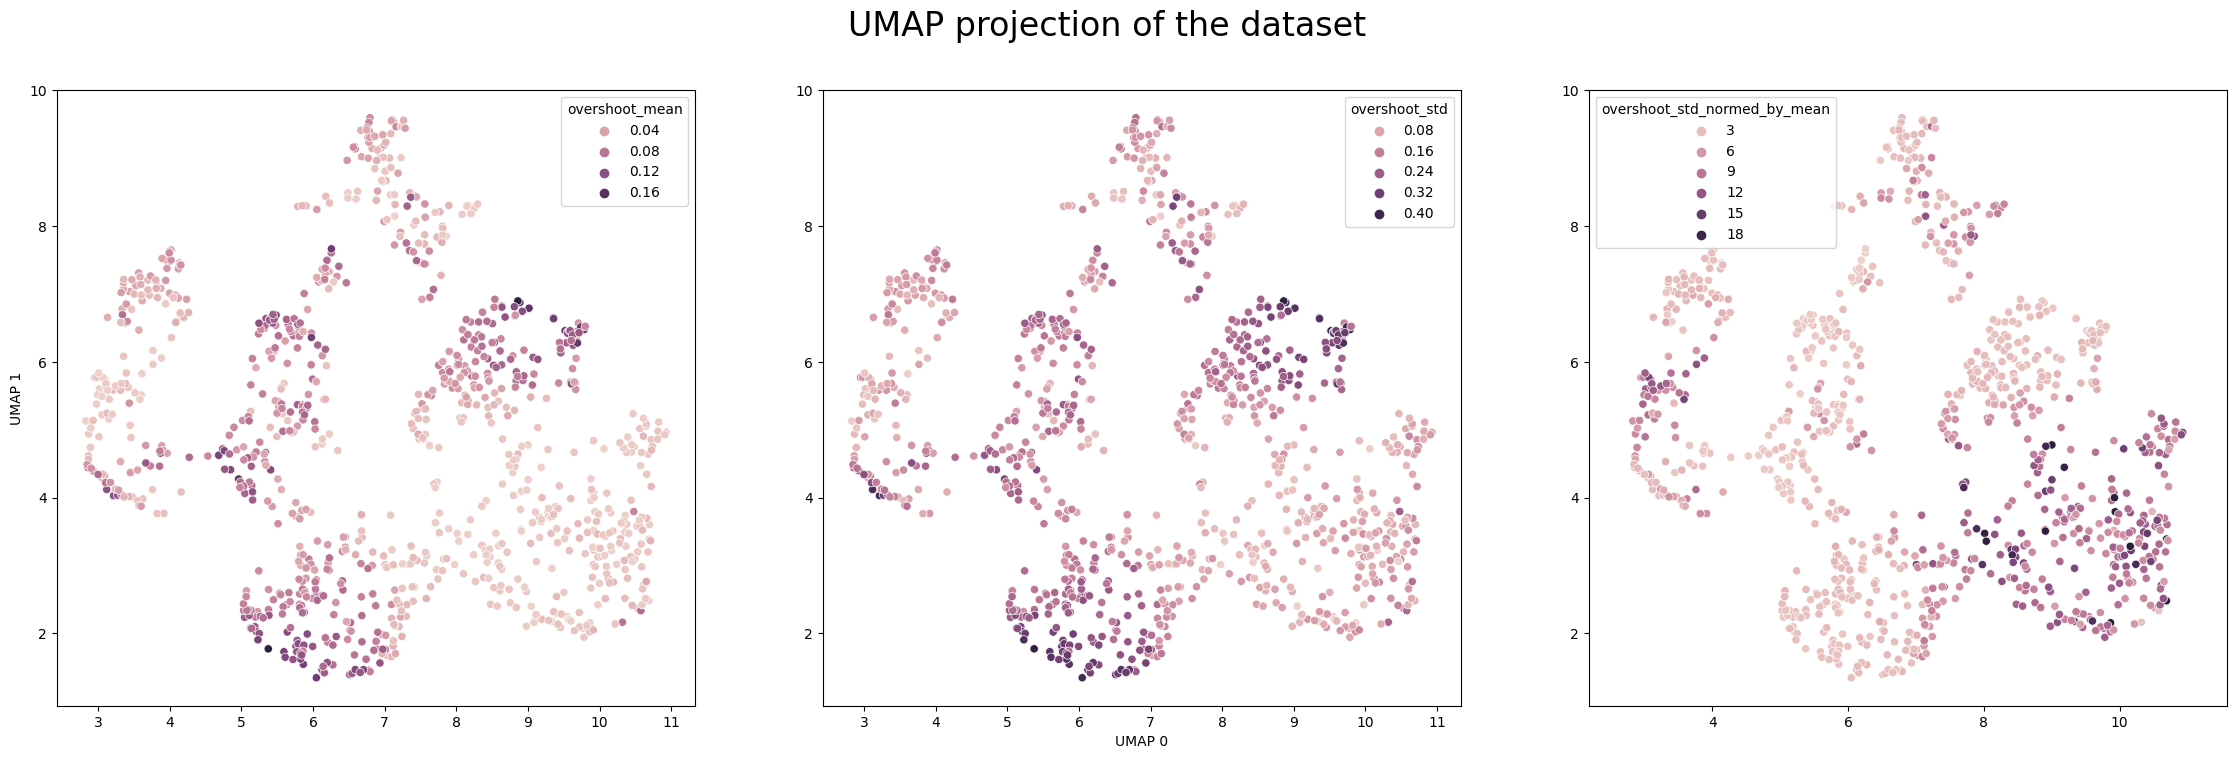

In [59]:
info['num_interacting_all'] = info['num_interacting'] + info['num_self_interacting']
for h in ['num_interacting_all', 'num_interacting', 'num_self_interacting', 'sensitivity_wrt_species-6', 'precision_wrt_species-6', 'RMSE', 'fold_change', 'overshoot']:
    hue = [
        info.groupby(['circuit_name']).agg({h: 'mean'}).to_numpy().squeeze(),
        info.groupby(['circuit_name']).agg({h: 'std'}).to_numpy().squeeze(),
        info.groupby(['circuit_name']).agg({h: lambda x: np.std(x) / np.where(np.mean(x) != 0, np.mean(x), 1)}).to_numpy().squeeze()
    ]
    if h in ['sensitivity_wrt_species-6', 'precision_wrt_species-6']:
        hue = [np.log(x) for x in hue]

    plt.figure(figsize=(28, 8))
    ax = plt.subplot(1,3,1)
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=hue[0]
    )
    plt.legend(title=h + '_mean')
    plt.ylabel('UMAP 1')
    ax = plt.subplot(1,3,2)
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=hue[1]
    )
    plt.xlabel('UMAP 0')
    plt.legend(title=h + '_std')
    ax = plt.subplot(1,3,3)
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=hue[2]
    )
    plt.legend(title=h + '_std_normed_by_mean')

    plt.gca().set_aspect('equal', 'datalim')
    plt.suptitle('UMAP projection of the dataset', fontsize=24);